In [1]:
import os
import random

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import seaborn as sns

# Pour afficher les graphiques dans le notebook
%matplotlib inline

# Chemin vers le CSV (depuis notebooks/)
CSV_PATH = "data/laion_aesthetic_subset_metadata.csv"

df = pd.read_csv(CSV_PATH)

print("Dataset chargé ✔️")
print(f"Nombre total d'exemples : {len(df)}")
print("Colonnes :", df.columns.tolist())

df.head()


Dataset chargé ✔️
Nombre total d'exemples : 19810
Colonnes : ['image_path', 'caption', 'width', 'height', 'similarity', 'punsafe', 'pwatermark', 'aesthetic_score']


,image_path,caption,width,height,similarity,punsafe,pwatermark,aesthetic_score
0,data/laion_aesthetic_subset\000000.jpg,Back view of woman holding skull,236.0,338.0,0.307866,0.002444,0.309885,6.594911
1,data/laion_aesthetic_subset\000001.jpg,"Henryk Semiradsky, Christ And The Sinner | 18...",500.0,250.0,0.300479,0.000059,0.050917,6.568064
2,data/laion_aesthetic_subset\000002.jpg,Suitsupply spring collection,600.0,450.0,0.316892,0.009035,0.231209,6.682418
3,data/laion_aesthetic_subset\000003.jpg,"luzfosca: Elliott Erwitt New York City, 1955 ...",701.0,1024.0,0.336167,0.000105,0.546471,6.675720
4,data/laion_aesthetic_subset\000004.jpg,Eiffel Tower - Milky Way Collage HD Metal pri...,884.0,1286.0,0.373617,0.000012,0.289776,6.850852


In [2]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19810 entries, 0 to 19809
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image_path       19810 non-null  object 
 1   caption          19810 non-null  object 
 2   width            19759 non-null  float64
 3   height           19779 non-null  float64
 4   similarity       19762 non-null  float64
 5   punsafe          19810 non-null  float64
 6   pwatermark       19605 non-null  float64
 7   aesthetic_score  19810 non-null  float64
dtypes: float64(6), object(2)
memory usage: 1.2+ MB


In [3]:
df["caption_len_words"] = df["caption"].fillna("").apply(lambda x: len(str(x).split()))
df[["caption", "caption_len_words"]].head()


,caption,caption_len_words
0,Back view of woman holding skull,6
1,"Henryk Semiradsky, Christ And The Sinner | 18...",13
2,Suitsupply spring collection,3
3,"luzfosca: Elliott Erwitt New York City, 1955 ...",12
4,Eiffel Tower - Milky Way Collage HD Metal pri...,14


In [4]:
num_cols = [
    "width",
    "height",
    "similarity",
    "punsafe",
    "pwatermark",
    "aesthetic_score",
    "caption_len_words",
]

df[num_cols].describe()


,width,height,similarity,punsafe,pwatermark,aesthetic_score,caption_len_words
count,19759.000000,19779.000000,19762.000000,1.981000e+04,19605.000000,19810.000000,19810.000000
mean,651.634698,571.179028,0.395685,3.282607e-02,0.228418,6.636410,11.788087
std,492.331776,421.792516,7.080395,1.564501e-01,0.207351,0.129823,13.431609
min,135.000000,113.000000,0.180529,1.908180e-09,0.000000,6.500002,1.000000
25%,370.000000,314.000000,0.308012,2.575886e-06,0.087470,6.541311,6.000000
50%,510.000000,444.000000,0.321569,1.829476e-05,0.157949,6.598223,9.000000
75%,768.000000,700.000000,0.339656,2.379715e-04,0.291162,6.691078,14.000000
max,7378.000000,8984.000000,800.000000,9.999361e-01,1.000000,7.633709,464.000000


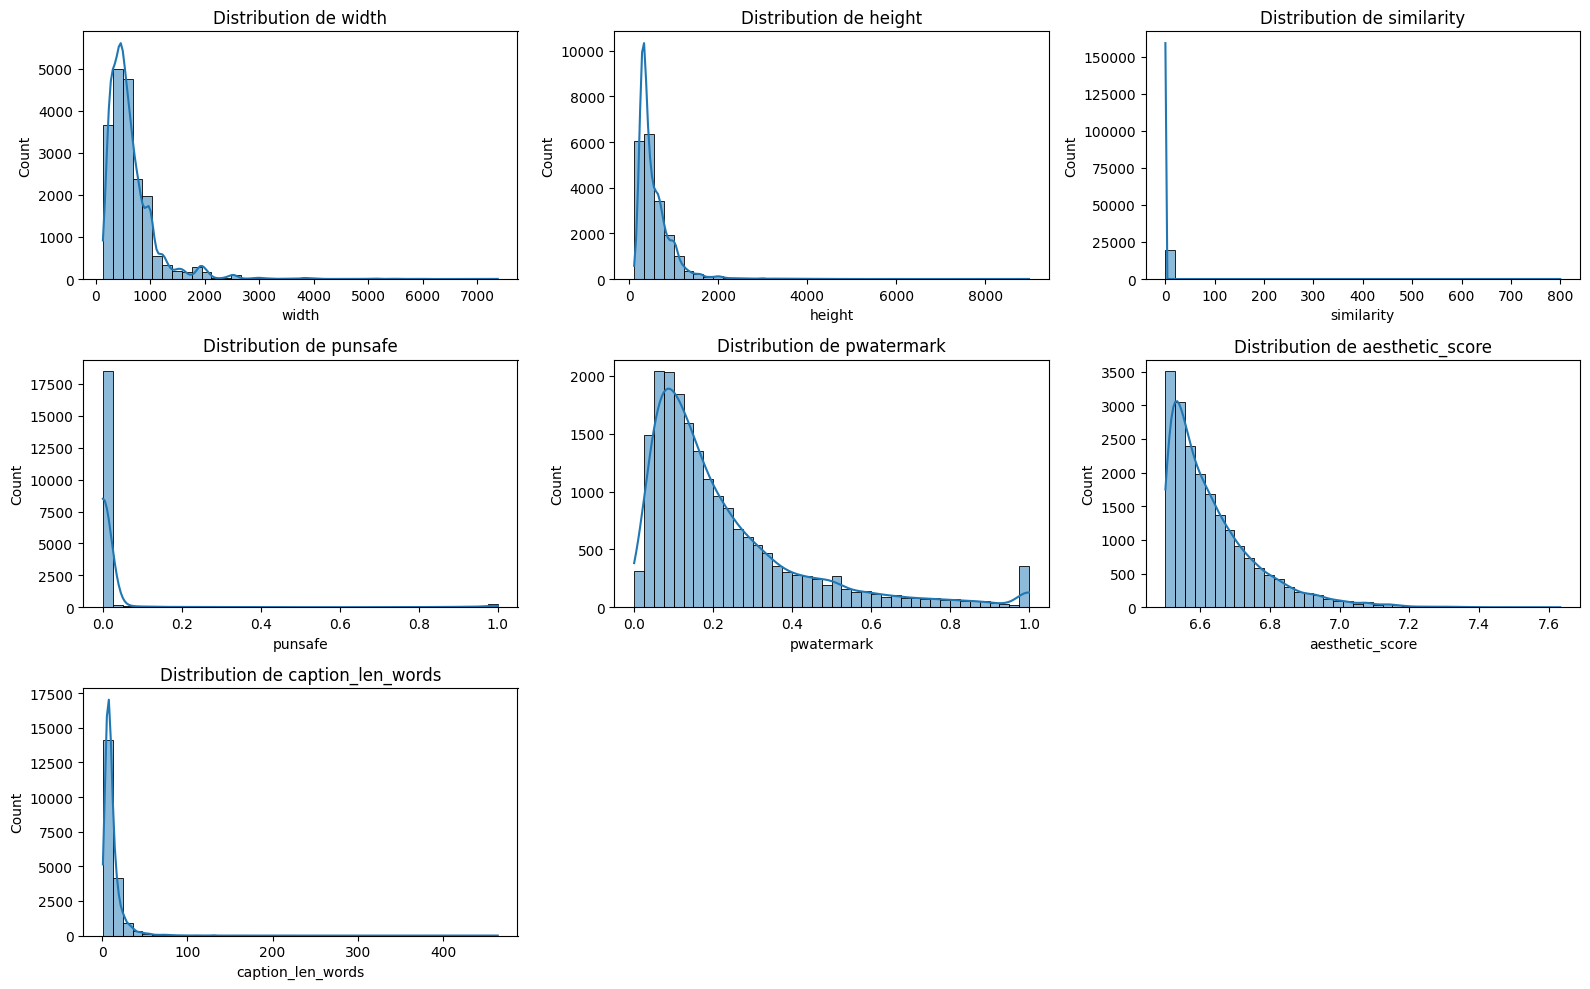

In [5]:
plt.figure(figsize=(16, 10))

for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=40, kde=True)
    plt.title(f"Distribution de {col}")

plt.tight_layout()
plt.show()


In [7]:
def show_random_images(df, n=6):
    samples = df.sample(n)
    plt.figure(figsize=(12, 8))

    for i, (_, row) in enumerate(samples.iterrows(), 1):
        img_path = row["image_path"]
        caption = row["caption"]

        if not os.path.exists(img_path):
            print(f"[⚠] Image manquante : {img_path}")
            continue

        try:
            img = Image.open(img_path)
        except Exception as e:
            print(f"[⚠] Erreur ouverture image {img_path}: {e}")
            continue

        plt.subplot(2, 3, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(caption[:60] + "..." if isinstance(caption, str) and len(caption) > 60 else str(caption))

    plt.tight_layout()
    plt.show()


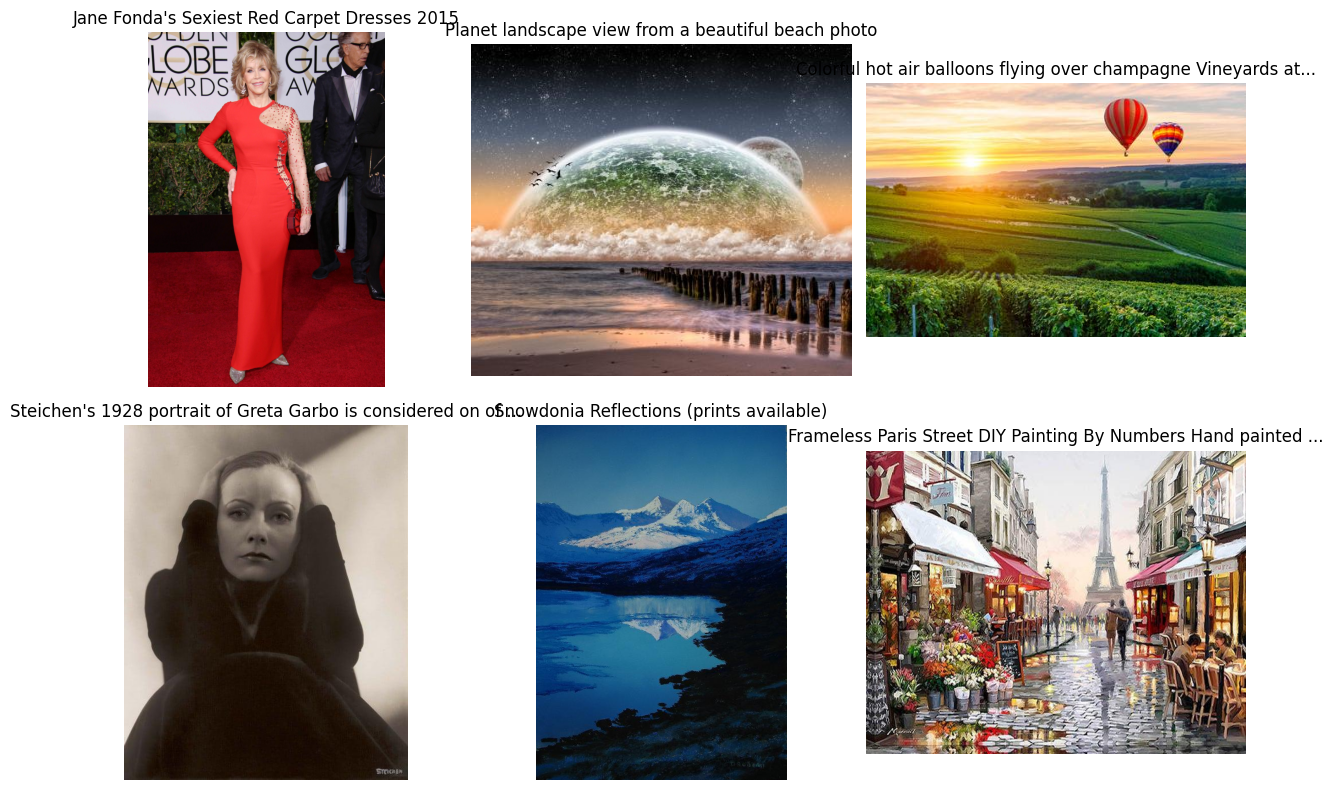

In [8]:
show_random_images(df, n=6)


In [9]:
anomalies = {
    "images_trop_petites": df[(df["width"] < 256) | (df["height"] < 256)],
    "captions_vides": df[df["caption_len_words"] == 0],
    "nsfw_eleves": df[df["punsafe"] > 0.5],
    "watermark_eleve": df[df["pwatermark"] > 0.5],
}

for name, subset in anomalies.items():
    print(f"\n🔍 {name} : {len(subset)} cas")



🔍 images_trop_petites : 3056 cas

🔍 captions_vides : 0 cas

🔍 nsfw_eleves : 602 cas

🔍 watermark_eleve : 1954 cas


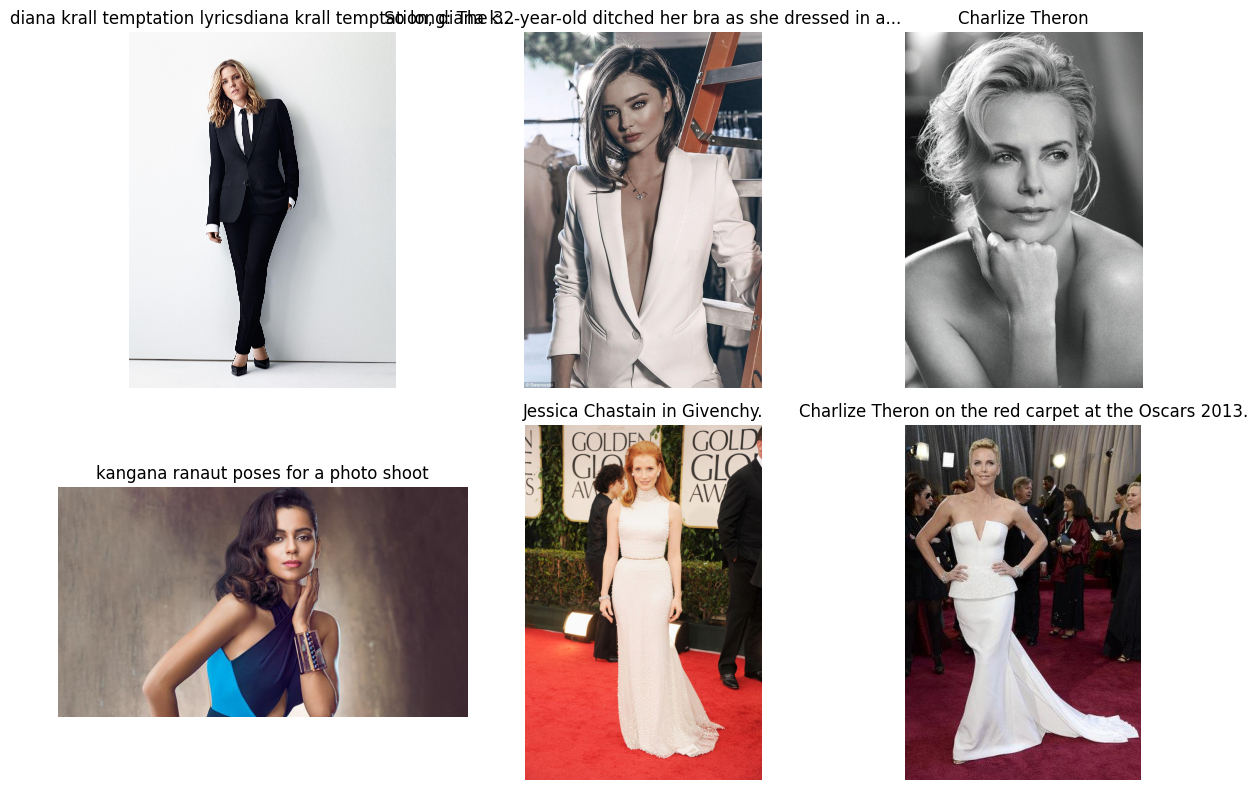

In [10]:
show_random_images(anomalies["nsfw_eleves"], n=6)


In [11]:
filtered_df = df[
    (df["width"] >= 256) &
    (df["height"] >= 256) &
    (df["caption_len_words"] >= 3) &
    (df["punsafe"] <= 0.3) &
    (df["pwatermark"] <= 0.2)
]

print(f"Images avant filtrage : {len(df)}")
print(f"Images après filtrage 'light' : {len(filtered_df)}")
print(f"Soit {len(filtered_df) / len(df) * 100:.1f}% conservées")


Images avant filtrage : 19810
Images après filtrage 'light' : 9059
Soit 45.7% conservées
